### Basic functions


In [ ]:
!pip install dcor

In [ ]:
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
import numpy as np
from fastdtw import fastdtw


mp_pose = mp.solutions.pose.Pose(
    static_image_mode=False,
    model_complexity=1,
    enable_segmentation=False
)

In [ ]:
def extract_pose_sequence(video_path):
    cap = cv2.VideoCapture(video_path)
    pose_sequence = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = mp_pose.process(rgb)

        if results.pose_landmarks:
            keypoints = []
            for lm in results.pose_landmarks.landmark:
                keypoints.append([lm.x, lm.y])
            pose_sequence.append(np.array(keypoints))  # (33, 2)

    cap.release()
    return pose_sequence


In [ ]:
def pose_to_motion_series(pose_seq):
    motion = []

    for i in range(1, len(pose_seq)):
        prev = pose_seq[i-1]
        curr = pose_seq[i]

        displacement = np.linalg.norm(curr - prev, axis=1)
        motion.append(np.mean(displacement))  # scalar per frame

    return np.array(motion)


In [ ]:
dtw_distS = []
dtw_pathlenS = []

In [ ]:

def vidFastdw(vid1, vid2):
    pose1 = extract_pose_sequence(vid1)
    pose2 = extract_pose_sequence(vid2)
    motion1 = pose_to_motion_series(pose1)
    motion2 = pose_to_motion_series(pose2)
    distance, path = fastdtw(
    motion1,
    motion2,
    dist=lambda a, b: np.linalg.norm(a - b))
    dtw_distS.append(distance)
    dtw_pathlenS.append(path)
    print("Distance: ",distance)
    return distance, path

### FastDTW-based motion scoring with latency–stability analysis across five arm-lowering video sets (Δ = 20° per step)

In [ ]:
import time
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
import numpy as np
from fastdtw import fastdtw


dtw_distS = []
dtw_pathlenS = []

mp_pose = mp.solutions.pose.Pose(
    static_image_mode=False,
    model_complexity=1,
    enable_segmentation=False
)


def extract_pose_sequence_with_stats(video_path):

    cap = cv2.VideoCapture(video_path)

    pose_sequence = []

    total_frames = 0
    pose_frames = 0
    frame_times = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        total_frames += 1

        start = time.perf_counter()

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = mp_pose.process(rgb)

        end = time.perf_counter()
        frame_times.append(end - start)

        if results.pose_landmarks:
            pose_frames += 1
            keypoints = [[lm.x, lm.y] for lm in results.pose_landmarks.landmark]
            pose_sequence.append(np.array(keypoints, dtype=np.float32))  # (33, 2)

    cap.release()

    avg_ms = 1000 * (np.mean(frame_times) if frame_times else float("nan"))
    p95_ms = 1000 * (np.percentile(frame_times, 95) if frame_times else float("nan"))

    stats = {
        "video": video_path,
        "total_frames_scanned": total_frames,
        "frames_with_pose": pose_frames,
        "pose_detection_rate_%": 100 * pose_frames / max(total_frames, 1),
        "avg_processing_ms_per_frame": avg_ms,
        "p95_processing_ms_per_frame": p95_ms
    }
    return pose_sequence, stats




def pose_to_motion_series(pose_seq):
    """
    1D motion series: mean joint displacement between consecutive pose frames.
    length = len(pose_seq)-1
    """
    motion = []
    for i in range(1, len(pose_seq)):
        prev = pose_seq[i - 1]
        curr = pose_seq[i]
        displacement = np.linalg.norm(curr - prev, axis=1)
        motion.append(np.mean(displacement))
    return np.array(motion, dtype=np.float32)

def z_normalize(x):
    x = np.asarray(x, dtype=np.float32)
    if len(x) == 0:
        return x
    return (x - x.mean()) / (x.std() + 1e-9)


# Stability (still video)

def stability_from_still_video(still_video_path):
    """
    Stability = std deviation of motion score when subject is still.
    Uses motion series std as stability (lower = more stable).
    """
    pose_seq, stats = extract_pose_sequence_with_stats(still_video_path)
    motion = pose_to_motion_series(pose_seq)

    stability_std = float(np.std(motion)) if len(motion) else float("nan")
    return stability_std, stats, motion


# FastDTW comparison + counts

def vidFastdw(vid1, vid2, normalize_series=True):
    pose1, stats1 = extract_pose_sequence_with_stats(vid1)
    pose2, stats2 = extract_pose_sequence_with_stats(vid2)

    motion1 = pose_to_motion_series(pose1)
    motion2 = pose_to_motion_series(pose2)

    if normalize_series:
        motion1 = z_normalize(motion1)
        motion2 = z_normalize(motion2)

    if len(motion1) == 0 or len(motion2) == 0:
        print("\n[ERROR] Not enough pose frames to compare.")
        print("Video1 stats:", stats1)
        print("Video2 stats:", stats2)
        return np.nan, [], stats1, stats2, motion1, motion2

    # For 1D motion series, abs distance is correct and stable.
    distance, path = fastdtw(motion1, motion2, dist=lambda a, b: abs(a - b))


    total_pairs_compared = len(path)
    unique_frames_v1 = len(set(i for i, j in path))
    unique_frames_v2 = len(set(j for i, j in path))
    coverage_v1 = 100 * unique_frames_v1 / max(len(motion1), 1)
    coverage_v2 = 100 * unique_frames_v2 / max(len(motion2), 1)

    # store results
    dtw_distS.append(float(distance))
    dtw_pathlenS.append(int(total_pairs_compared))

    print("\n==============================")
    print(f"Comparing: {vid1}  vs  {vid2}")
    print("------------------------------")
    print("DTW distance (lower=more similar):", float(distance))
    print("Total DTW aligned frame-pairs compared (len(path)):", total_pairs_compared)
    print(f"Unique frames compared: video1 {unique_frames_v1}/{len(motion1)} ({coverage_v1:.1f}%)")
    print(f"Unique frames compared: video2 {unique_frames_v2}/{len(motion2)} ({coverage_v2:.1f}%)")

    print("\n--- Video 1 scanning/pose/latency ---")
    print(stats1)
    print("--- Video 2 scanning/pose/latency ---")
    print(stats2)

    print("\nCollected distances so far:", distance)

    print("==============================\n")

    return distance, path, stats1, stats2, motion1, motion2

def plot_motion_overlap(motion1, motion2, title="Motion series overlap"):
    plt.figure(figsize=(10, 4))
    plt.plot(motion1, label="Motion 1")
    plt.plot(motion2, label="Motion 2")
    plt.title(title)
    plt.xlabel("Time index")
    plt.ylabel("Motion (normalized)" if (abs(np.mean(motion1)) < 2 and abs(np.mean(motion2)) < 2) else "Motion")
    plt.legend()
    plt.grid(True)
    plt.show()


dist1S, path1S, s11, s12, m11, m12 = vidFastdw("degree1.mp4", "degree1.mp4")
dist2S, path2S, s21, s22, m21, m22 = vidFastdw("degree1.mp4", "degree2.mp4")
dist3S, path3S, s31, s32, m31, m32 = vidFastdw("degree1.mp4", "degree3.mp4")
dist4S, path4S, s41, s42, m41, m42 = vidFastdw("degree1.mp4", "degree4.mp4")
dist5S, path5S, s51, s52, m51, m52 = vidFastdw("degree1.mp4", "degree5.mp4")


# plot_motion_overlap(m21, m22, title="degree1 vs degree2 motion overlap")

# Put a still/no-movement clip path here:
# stability_std, still_stats, still_motion = stability_from_still_video("still_video.mp4")
# print(f"Stability (std of motion score when still): {stability_std:.6f}")
# print("Still video stats:", still_stats)
# plt.figure(figsize=(10,4))
# plt.plot(still_motion)
# plt.title("Still video motion score (should be near flat)")
# plt.xlabel("Time index")
# plt.ylabel("Motion score")
# plt.grid(True)
# plt.show()



Comparing: degree1.mp4  vs  degree1.mp4
------------------------------
DTW distance (lower=more similar): 81.87664508190937
Total DTW aligned frame-pairs compared (len(path)): 213
Unique frames compared: video1 185/185 (100.0%)
Unique frames compared: video2 185/185 (100.0%)

--- Video 1 scanning/pose/latency ---
{'video': 'degree1.mp4', 'total_frames_scanned': 186, 'frames_with_pose': 186, 'pose_detection_rate_%': 100.0, 'avg_processing_ms_per_frame': 333.86206720430437, 'p95_processing_ms_per_frame': 611.0150749999548}
--- Video 2 scanning/pose/latency ---
{'video': 'degree1.mp4', 'total_frames_scanned': 186, 'frames_with_pose': 186, 'pose_detection_rate_%': 100.0, 'avg_processing_ms_per_frame': 279.17408978494734, 'p95_processing_ms_per_frame': 355.12650000003987}

Collected distances so far: 81.87664508190937


Comparing: degree1.mp4  vs  degree2.mp4
------------------------------
DTW distance (lower=more similar): 126.42338165338151
Total DTW aligned frame-pairs compared (len(pat

### FastDTW-based motion scoring  across five arm-lowering video sets (Δ = 20° per step)

In [ ]:
dtw_distSNew = []
dtw_pathlenSNew = []

In [ ]:

def vidFastdw(vid1, vid2):
    pose1 = extract_pose_sequence(vid1)
    pose2 = extract_pose_sequence(vid2)
    motion1 = pose_to_motion_series(pose1)
    motion2 = pose_to_motion_series(pose2)
    distance, path = fastdtw(
    motion1,
    motion2,
    dist=lambda a, b: np.linalg.norm(a - b))
    dtw_distSNew.append(distance)
    dtw_pathlenSNew.append(path)
    print("Distance: ",distance, "\n")
    return distance, path
dist1S, path1S = vidFastdw("degree1.mp4", "degree1.mp4")
dist2S, path2S = vidFastdw("degree1.mp4", "degree2.mp4")
dist3S, path3S = vidFastdw("degree1.mp4", "degree3.mp4")
dist4S, path4S = vidFastdw("degree1.mp4", "degree4.mp4")
dist5S, path5S = vidFastdw("degree1.mp4", "degree5.mp4")

Distance:  0.013873613608709883 

Distance:  0.12407265136849982 

Distance:  0.13263686726835902 

Distance:  0.11105075863083347 

Distance:  0.854376554682189 



### FastDTW-Based Motion Scoring Across 20 Video Sets of Correct and Incorrect Executions

In [ ]:
dtw_dist = []
dtw_pathlen = []

In [ ]:
def vidFastdw(vid1, vid2):
    pose1 = extract_pose_sequence(vid1)
    pose2 = extract_pose_sequence(vid2)
    motion1 = pose_to_motion_series(pose1)
    motion2 = pose_to_motion_series(pose2)
    distance, path = fastdtw(
    motion1,
    motion2,
    dist=lambda a, b: np.linalg.norm(a - b))
    dtw_dist.append(distance)
    dtw_pathlen.append(path)
    print("Distance: ",dtw_distS, "   PathLength: ",dtw_pathlenS)
    return distance, path

In [ ]:
dist1, path1 = vidFastdw("vidy1R.mp4", "vidy1W.mp4")
dist2, path2 = vidFastdw("vidy2R.mp4", "vidy2W.mp4")
dist3, path3 = vidFastdw("vidy3R.mp4", "vidy3W.mp4")
dist4, path4 = vidFastdw("vidy4R.mp4", "vidy4W.mp4")
dist5, path5 = vidFastdw("vidy5R.mp4", "vidy5W.mp4")

dist6, path6 = vidFastdw("vidy6R.mp4", "vidy6W.mp4")
dist7, path7 = vidFastdw("vidy7R.mp4", "vidy7W.mp4")
dist8, path8 = vidFastdw("vidy8R.mp4", "vidy8W.mp4")
dist9, path9 = vidFastdw("vidy9R.mp4", "vidy9W.mp4")
dist10, path10 = vidFastdw("vidy10R.mp4", "vidy10W.mp4")

dist11, path11 = vidFastdw("vidy11R.mp4", "vidy11W.mp4")
dist12, path12 = vidFastdw("vidy12R.mp4", "vidy12W.mp4")
dist13, path13 = vidFastdw("vidy13R.mp4", "vidy13W.mp4")
dist14, path14 = vidFastdw("vidy14R.mp4", "vidy14W.mp4")
dist15, path15 = vidFastdw("vidy15R.mp4", "vidy15W.mp4")

dist16, path16 = vidFastdw("vidy16R.mp4", "vidy16W.mp4")
dist17, path17 = vidFastdw("vidy17R.mp4", "vidy17W.mp4")
dist18, path18 = vidFastdw("vidy18R.mp4", "vidy18W.mp4")
dist19, path19 = vidFastdw("vidy19R.mp4", "vidy19W.mp4")
dist20, path20 = vidFastdw("vidy20R.mp4", "vidy20W.mp4")

In [ ]:
dtw_dist

[1.4443091124351228,
 1.1329527736120628,
 0.3638635119897738,
 1.9182942192175838,
 2.0026258169252147,
 2.09242459343642,
 0.7748503817268837,
 1.6605106698214107,
 0.27269867974044026,
 1.8897593318004728,
 1.1415707184455168,
 1.7499217351656051,
 1.041751345733093,
 2.1269422189865432,
 1.4358455348910606,
 1.2688126184976287,
 0.7072545473785702,
 1.3889986584693101,
 0.845174014921118,
 1.3085311450161368]

### FastDTW-based motion scoring Graph Plotting across five arm-lowering video sets (Δ = 20° per step)

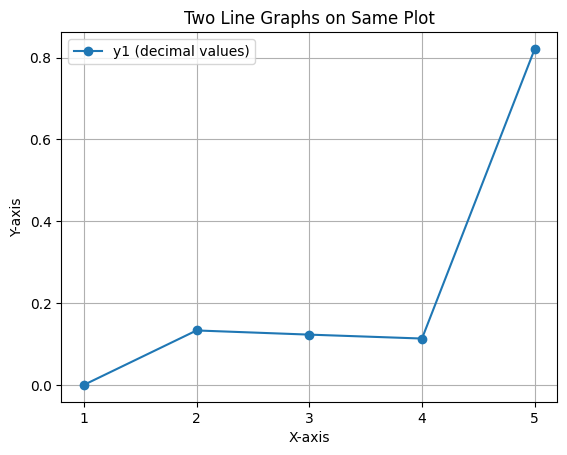

In [ ]:
import matplotlib.pyplot as plt

# Data
y1 = [0.0,
 0.13308398726336107,
 0.12289964108230236,
 0.11332952389576481,
 0.8209656158578977]

x = [1, 2, 3, 4, 5]

# Plot both lines
plt.plot(x, y1, marker='o', linestyle='-', label="y1 (decimal values)")


# Force exactly 5 x-axis ticks
plt.xticks(x)

plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Two Line Graphs on Same Plot")
plt.legend()
plt.grid(True)

plt.show()
